In [1]:
import numpy as np
import torch.nn as nn
import torch
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using " + device)
def csvReader(csvFiles, printResults):
    data = pd.read_csv(csvFiles)
    if printResults:
        print(data)
    x1 = np.asarray(data.Height,dtype=np.float32)
    x2 = np.asarray(data.Weight,dtype=np.float32)
    label = [1 if x=='Male' else 0 for x in data.Gender]
    X = np.column_stack((x1,x2))
    y = np.asarray(label,dtype=np.float32)
    return X,y

Using cpu


In [2]:
#! Task 1 : 
#           a. Read the train.csv and test.csv as training and test samples
#           b. Normalize the data
#           c. carefull with the dimension, use torch.unsqueeze and torch.squeeze while required.
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab1'
myDrive = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab1'

X, Y = csvReader(myDrive+'/Data/train.csv', False)
Xt, Yt = csvReader(myDrive+'/Data/test.csv', False)

X = torch.tensor(X/np.max(X)).unsqueeze(0).to(device)
Y = torch.tensor(Y).unsqueeze(0).to(device)
Xt = torch.tensor(Xt/np.max(Xt)).unsqueeze(0).to(device)
Yt = torch.tensor(Yt).unsqueeze(0).to(device)

#X,Xt,Y,Yt = None, None, None, None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data	  Question     SP-1.2.odt
Examples  Report.gdoc  T2_MLP_Example_Theory_Class.ipynb


In [0]:
#!Task 2 : Define your Neural Network

class Neural_Network(nn.Module):
    def __init__(self,inputNode=2,hiddenNode = 3, outputNode=1,lmbda  = 0):   
        super(Neural_Network, self).__init__()     
        #Define Hyperparameters
        self.lmbda = lmbda
        self.reg_loss = 0
    
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(inputNode, hiddenNode),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddenNode, outputNode),
            torch.nn.Sigmoid(),
        )
        
        # Weight initilization
        for m in self.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal(m.weight, mean=0, std=0.01)
                nn.init.constant(m.bias, 0)
                
        
    def init_weights(m):
        print(m)
        if type(m) == nn.Linear:
            m.weight.data.fill_(0.001)
            print(m.weight)
        
        
    def forward(self, X):
        return self.fc(X)
        
    def loss(self, yHat, y):
        l2loss = torch.nn.functional.mse_loss(y, yHat) 
        return l2loss #+ self.reg_loss


In [0]:
#!Task 3 : Define your Training 
def train(NN,X, y,Xt,yt,epoch = 5000,optimizer = None):
    list_loss = []
    for e in range(epoch):
        for i in range(X.size(1)):
            result = NN(X[:,i])
            loss = NN.loss(result, y[:,i])
            loss.backward()
            optimizer.step()
            list_loss.append(loss.item())
            optimizer.zero_grad()

    list_loss2 = []
    with torch.no_grad():
        for i in range(Xt.size(1)):
            result = NN(Xt[:,i])
            loss = NN.loss(result, yt[:,i])
            list_loss2.append(loss.item())
    return list_loss, list_loss2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


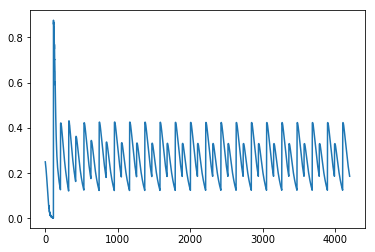

In [5]:
NN = Neural_Network(lmbda = .001).to(device)

#!Task 4 : define your optimizer 
optimizer = torch.optim.Adam(NN.parameters(), lr=0.01, betas=(0.9, 0.999))
list_loss, list_loss2 = train(NN,X,Y,Xt,Yt,20,optimizer)

import matplotlib.pyplot as plt
plt.plot(list_loss)
plt.show()


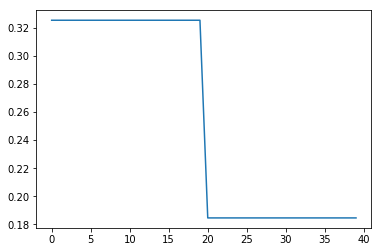

In [6]:
plt.plot(list_loss2)
plt.show()

In [7]:
#!Task 5 : Train and plot the result.

def plot_decision_boundary(X, y):
    x1 = np.linspace(X[:,0].min(), X[:, 0].max(), 200)
    x2 = np.linspace(X[:,1].min(), X[:, 1].max(), 200)
    X1, X2 = np.meshgrid(x1, x2)
    pts = np.c_[X1.ravel(), X2.ravel()]
    f = NN.forward(torch.from_numpy(pts).float().cuda()).cpu().detach().reshape(X1.shape)
    
    plt.figure(figsize=(7,7))
    plt.scatter(X[:,0], X[:,1], c=y, s=30)
    plt.contour(X1, X2, f, 1, levels=[0.5])
    plt.show()
    
plot_decision_boundary(X.cpu().detach().numpy(), Y.cpu().squeeze().numpy())

RuntimeError: ignored